# Choosing a matching algorithm using metrics

*Transmorph* provides tools to easily choose between the various algorithms for a given use case. In this tutorial, we demonstrate how we can use *transmorph* matching statistics and plotting tools to select a matching algorithm in order to identify common cell types across batches. We will use a real-life data bank downloadable via our API to carry out the testings. You will learn in this example basic usage of our *model* API, giving you more control on model design and allowing you to create your own models.

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Head and neck cancer databank contains eleven batches in the AnnData format, each expressed in its 5,000 most variable genes space. Cell types are annotated by the .obs key "class_type", and their malignant state is annotated by the .obs key "class_iscancer". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [1]:
from transmorph.datasets import load_zhou_10x

# Format: {patient_label -> AnnData}
datasets = load_zhou_10x()
dataset_keys = list(datasets.keys()) # Save labels for plotting

# Models take as input a list of AnnData objects
datasets = list(datasets.values())

In [20]:
for adata in datasets:
    print(f"{adata.n_obs} smp x {adata.n_vars} ftr, \t obs: {', '.join(adata.obs.columns)}")

14322 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
5020 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
8362 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
3331 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
866 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
1601 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
10575 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
3007 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
6556 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
6526 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer
4391 smp x 5000 ftr, 	 obs: n_genes, class_type, class_iscancer


### Creating a matching test model

Let us define a small helper function that will help us creating a minimalistic model to assess matching quality. This minimalistic model will be composed by an *input* layer to receive datasets, and a *matching* layer that will match samples across batches. We do not need *output* layer in this case, as we won't need to compute integrated representations in order to test matching accuracy. 

Let us start by having a look at the imports. We start by importing model building blocks, namely the *Model* class and both layers we need. We then import preprocessing algorithms to handle high dimensional single-cell data:
- CommonFeatures will automatically embed AnnData objects in their largest common features space. It is necessary as our datasets do not share the same features set.
- Standardize will center and standardize features of each dataset, to deal with scaling issues
- PCA will embed all datasets together in a common PC space, which is useful to diminish effect of noise and extract high variance axes.

Finally, as we deal with large datasets we choose to use a subsampling scheme. This will allow to only compute matching between a subbatch of each dataset, greatly improving computational efficiency of many of our algorithms. We choose a vertex cover-based subsampling, which provides good topological properties, guaranteeing all regions of the datasets to be represented.

In [24]:
# We import building blocks
from transmorph.engine import Model
from transmorph.engine.layers import LayerInput, LayerMatching

# We add algorithms and preprocessings we need
# to deal with high dimensional single-cell data
from transmorph.engine.transforming import (
    CommonFeatures, 
    Standardize, 
    PCA
)

# Subsampling algorithm
from transmorph.engine.subsampling import VertexCover

We are now ready to implement our function dedicated to creating a testing model around a given matching algorithm. This function starts by instanciating the layers, loading them with algorithms and initializing the model.

In [25]:
def create_model_test_matching(matching_algorithm, evaluator) -> Model:
    """
    This function takes a matching algorithm as input, 
    and returns a minimalistic transmorph model with 
    this algorithm ready to be tested.
    """
    # Layers instanciation
    linput = LayerInput()
    lmatch = LayerMatching(
        matching=matching_algorithm,
        subsampling=VertexCover(n_neighbors=3), # The higher, the smaller batches
        evaluators=[evaluator]
    )
    
    # Loading preprocessings to LayerMatching to deal with 
    # RNA-seq single-cell datasets
    lmatch.add_transformation(CommonFeatures())
    lmatch.add_transformation(Standardize(center=True, scale=True))
    lmatch.add_transformation(PCA(n_components=30))
    
    # Connecting layers and creating the model
    linput.connect(lmatch)
    return Model(input_layer=linput)

We can now load candidates matching algorithm to test, and an evaluator to quantitatively assess matching quality. Let us pick mutual nearest neighbors (MNN) and optimal transport (OT) as matching, and matching_edge_accuracy as evaluator. 
- k-MNN matches all pairs of cells that reciprocally belong to the k-nearest neighbors set of the other, within their batch. 
- OT computes the laziest way to move samples from one dataset to the other, transporting as few mass as possible, on distances as short as possible. The optimal transport plan can be interpreted as a weighted matching.
- Edge accuracy computes the weighted frequency of matching edges that link cells of the same class.

In [6]:
# MNN and OT matching algorithms
from transmorph.engine.matching import MNN, OT

# Statistical function to test matching
from transmorph.engine.evaluators import matching_edge_accuracy

### Comparing MNN and OT on Zhou databank

We now have all tools loaded to start benchmarking algorithms. Let us create both models, and run them. They will both compute matchings between all pairs of datasets.

In [26]:
# An evaluator is provided as a tuple (name, function). This 
# is useful to provide multiple evaluators in the same layer.
evaluator = ("accuracy", matching_edge_accuracy(label="class_type"))

model_mnn = create_model_test_matching(
    MNN(n_neighbors=30), # k=30 is a decent guess in general
    evaluator
)
model_ot = create_model_test_matching(
    OT(), # Basic OT does not need parameters
    evaluator
)

# We will get a warning as our models do
# not contain an output layer, which is 
# fine in this case.
model_mnn.fit(datasets)
model_ot.fit(datasets)

For each model, we must retrieve its matching layer. This can be done through the method get_layers_by_type(), which expects a layer type and returns all layers that have this type.

In [30]:
# This method returns a list of layers, so we have to 
# retrieve its first index.
lmatch_mnn = model_mnn.get_layers_by_type(LayerMatching)[0]
lmatch_ot = model_ot.get_layers_by_type(LayerMatching)[0]

We can start by comparing time spent by each of our algorithms, using get_time_spent() method. As we can see, in this example MNN was quite more efficient than OT.

In [34]:
print(f"Time MNN: {lmatch_mnn.get_time_spent()}s")
print(f"Time OT: {lmatch_ot.get_time_spent()}s")

Time MNN: 29.688555240631104s
Time OT: 117.86043572425842s


Then, we can use plotting tools to display for each algorithm a heatmap of the evaluator we chose. First, for matching MNN.

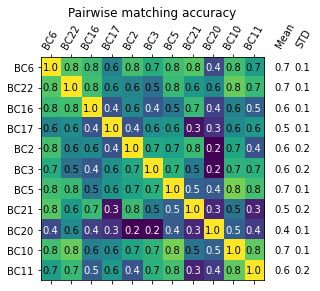

In [37]:
from transmorph.utils.plotting import plot_matching_eval

plot_matching_eval(lmatch_mnn, "accuracy", dataset_keys)

Then, for OT.

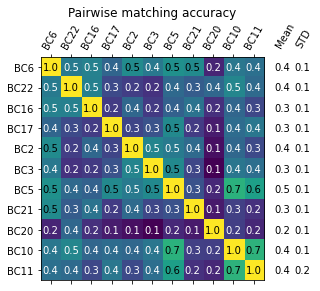

In [36]:
plot_matching_eval(lmatch_ot, "accuracy", dataset_keys)

We can see MNN edges are much more reliable than OT edges. MNN being also quicker than OT, we should definitely choose MNN as a matching for our Zhou databank. We also see the BC20 dataset to be quite problmatic in both cases, with poor matching accuracy. If the final integration is not satisfying, this dataset may be a good suspect for it.

In this tutorial, we demonstrated how important matching choice can be for a successful dataset integration. Indeed, an incorrect guess of similar cell types across batches can only lead to complete confusion at the end of integration. We have also shown how the *transmorph* package helps to choose the most suitable matching algorithm for a given data bank, while still encouraging model customization and user agency. 